# Imports


In [1]:
# ¡¡¡ Conectar con Google Drive !!!

# Se instala e importa import_ipynb para poder acceder a clases/funciones de otros notebooks
!pip install -q import-ipynb

# Se cambia al directorio donde esté el notebook con las clases a importar
%cd "/content/drive/MyDrive/Colab_Notebooks"

#!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install -q -U albumentations

!pip install -q torchmetrics


/content/drive/MyDrive/Colab_Notebooks
     |████████████████████████████████| 102 kB 3.6 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 282 kB 4.3 MB/s 


In [2]:
# Manejo y representación de datos
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Pytorch 
import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Dataset y Dataloader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset , DataLoader

# Transformaciones
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.transform import resize

# Modelo
import import_ipynb
from models import VDSR

# Métricas
from torchmetrics.functional import ssim
from torchmetrics.functional import psnr

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

importing Jupyter notebook from models.ipynb


# Rutas y dataframe

In [ ]:
img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/' # Carpeta que contiene las imágenes

# División en entrenamiento y validación
df = pd.DataFrame(os.listdir(img_fol), columns = ['name'])       # Se estructura de forma tabular el contenido de la carpeta 'img_fol'
df = df.iloc[:2000]    # Se reduce el dataframe a 2000 imagenes
df_train, df_val = train_test_split(df, test_size=.2, random_state=42, shuffle=True, stratify=None) 

# Tras realizar la división, es necesario reiniciar los índices
df_train = df_train.reset_index()
df_val = df_val.reset_index()

print(f"Total: {len(df)} -- Entrenamiento: {len(df_train)} -- Validación: {len(df_val)}")



Total: 2000 -- Entrenamiento: 1600 -- Validación: 400


# Pruebas
Sección de prueba para aplicar submuestreo a una imagen 

In [ ]:
# Se carga una imagen
img_name=df['name'][0]
img_path=os.path.join(img_fol,img_name)    # Ruta completa imagen
img = cv2.imread(img_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))

# Se muestra la imagen original
plt.subplot(1,3,1)
plt.title("Imagen original")
plt.imshow(img)

# Transformaciones
transforms = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

# Se aplican las transformaciones y se representa
img_transform = transforms(image=img)['image']
plt.subplot(1,3,2)
plt.title("Imagen transformada")
plt.imshow(img_transform.numpy().transpose(1,2,0))

# Se aplica el submuestreo a la imagen con transformaciones
# La imagen continúa con el mismo numero de canales, pero se reduce x4 cada dimensión
img_resize = resize(img_transform.numpy(), (3,img_transform.shape[1]//4,img_transform.shape[2]//4), anti_aliasing=True)

# Se realiza una interpolación bicúbica para tener las mismas dimensiones que en la imagen original
img_resize = cv2.resize(img_resize.transpose(1,2,0), (img_transform.shape[1],img_transform.shape[2]), interpolation = cv2.INTER_CUBIC)
img_resize = img_resize.transpose(2,0,1)
print(img_resize.shape)
plt.subplot(1,3,3)
plt.title("Imagen transformada con submuestreo")
plt.imshow(img_resize.transpose(1,2,0))


# DataSet y DataLoader


In [ ]:
class CarDataset(Dataset):
    def __init__(self, df, transforms = None):
        # self.df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/carvana/train_masks.csv')
        self.df = df 
        self.transforms = transforms
        self.img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/'
        self.mask_fol = '/content/drive/MyDrive/Colab_Notebooks/carvana/train_masks/' 
       

    def __getitem__(self, idx):
        img_name=self.df['name'][idx]
        img_path=os.path.join(self.img_fol,img_name)    # Ruta completa imagen

        img_HR = cv2.imread(img_path)      # Se carga la imagen
        img_HR= cv2.cvtColor(img_HR, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img_HR = self.transforms(image=img_HR)['image']

        # Factor de escala x4 en cada dimensión. Se mantiene el nº de canales
        img_LR = resize(img_HR.numpy(), (3,img_HR.shape[1]//4,img_HR.shape[2]//4), anti_aliasing=True)
        
        # Se realiza una interpolación bicúbica para tener las mismas dimensiones que en la imagen original
        img_LR = cv2.resize(img_LR.transpose(1,2,0), (img_HR.shape[1],img_HR.shape[2]), interpolation = cv2.INTER_CUBIC)
        img_LR = img_LR.transpose(2,0,1)
        return img_HR, img_LR

    def __len__(self):
        return len(self.df)

In [ ]:
# Transformaciones
transforms = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

# Datasets de entrenamiento y evaluación
carDatasetTrain = CarDataset(df=df_train, transforms=transforms)
carDatasetval = CarDataset(df=df_val, transforms=transforms)

# Dataloaders de entrenamiento y evaluación
train_dataloader = DataLoader(carDatasetTrain, batch_size=4,
                        shuffle=True, num_workers=0)
val_dataloader = DataLoader(carDatasetval, batch_size=4,
                        shuffle=False, num_workers=0) # El dataloader de validación es fijo, no debe tener shuffle

In [ ]:
# Se instancia el modelo y se envía a la gpu si está disponible
model = VDSR()
model.to(device)

# Función de pérdida 
criterion = nn.MSELoss()

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train
def train(epoch,epochs,tloader) :
    
    model.train() # Se establece el modelo en modo entrenamiento
    
    n_train = len(train_dataloader) # Se calcula el número de batches de entrenamiento

    tloader.set_description(f'EPOCH {epoch+1}')
    
    # Se inicializan a 0 las variables que almacenarán las métricas   
    # obtenidas en cada batch
    epoch_loss,epoch_psnr,epoch_ssim, epoch_rmse = 0,0,0,0

    
    for img_HR, img_LR in tloader :

        # El batch de imágenes HR y LR se envían a la GPU si está disponible
        img_HR = img_HR.to(device, dtype=torch.float32)
        img_LR  = img_LR.to(device, dtype=torch.float32)

        # Se obtiene la salida del modelo (batch de imágenes SR)
        img_SR = model(img_LR)

        # Se obtiene el valor de la pérdida
        loss = criterion(img_SR,img_HR)
        epoch_loss += loss.item()      

        # Back propagation
        loss.backward()

        # Actualización de los pesos
        optimizer.step()

        # Se pone a cero los gradientes
        optimizer.zero_grad()

        # Se calcula la PSNR
        psnr_score = psnr(img_SR,img_HR)
        epoch_psnr += psnr_score.item()      

        # Se calcula el SSIM
        ssim_score = ssim(img_SR, img_HR)
        epoch_ssim += ssim_score.item()   

        # Se calcula el RSME
        rmse_score = torch.sqrt(loss)
        epoch_rmse += rmse_score.item()   

        tloader.set_postfix(loss=loss.item(), psnr=psnr_score.item(), ssim=ssim_score.item(), rmse=rmse_score.item())
 
    print(f'Train Loss Epoch : {(epoch_loss/n_train)}')
    print(f'Train PSNR Epoch : {(epoch_psnr/n_train)}')
    print(f'Train SSIM Epoch : {(epoch_ssim/n_train)}')
    print(f'Train RMSE Epoch : {(epoch_rmse/n_train)}')

    # Se devuelve el valor medio de cada métrica
    return [(epoch_loss/n_train),(epoch_psnr/n_train),(epoch_ssim/n_train),(epoch_rmse/n_train)]

    
def validation(vloader) :
    
    model.eval() # Se establece el modelo en modo entrenamiento

    n_val = len(val_dataloader) # Se calcula el número de batches de evaluación
    
    vloader.set_description(f'Validation')
    
    # Se inicializan a 0 las variables que almacenarán las métricas   
    # obtenidas en cada batch
    epoch_loss,epoch_psnr,epoch_ssim, epoch_rmse = 0,0,0,0

    # Contador del nbatches transcurridos
    nbatch = 0

    with torch.no_grad():
        for img_HR, img_LR in vloader :

            nbatch += 1

            # El batch de imágenes HR y LR se envían a la GPU si está disponible
            img_HR = img_HR.to(device)
            img_LR  = img_LR.to(device)
                
            # Se obtiene la salida del modelo (batch de imágenes SR)
            img_SR = model(img_LR)
            
            # Se obtiene el valor de la pérdida
            loss = criterion(img_SR,img_HR)
            epoch_loss += loss.item()  
            
             # Se calcula la PSNR
            psnr_score = psnr(img_SR,img_HR)
            epoch_psnr += psnr_score.item()      

            # Se calcula el SSIM
            ssim_score = ssim(img_SR, img_HR)
            epoch_ssim += ssim_score.item()  

            # Se calcula el RSME
            rmse_score = torch.sqrt(loss)
            epoch_rmse += rmse_score.item() 

            vloader.set_postfix(loss=loss.item(), psnr=psnr_score.item(), ssim=ssim_score.item(), rmse=rmse_score.item())

            if nbatch == 1:
                plt.figure(figsize=(15,15))
                # No es necesario dividir las métricas porque es el valor acumulado de un único batch
                plt.suptitle(f"Loss: {epoch_loss:.2f} -- RMSE: {epoch_rmse:.2f} -- PSNR: {epoch_psnr:.2f} -- SSIM: {epoch_ssim:.2f}", fontsize=20, y=0.92)
                for i in range(bs):
                    plt.subplot(bs,3,(3*i+1))
                    plt.title(f"HR -- Epoch: {epoch+1}")
                    plt.imshow(img_HR[i].cpu().numpy().transpose(1,2,0))
                    plt.subplot(bs,3,(3*i+2))
                    plt.title(f"LR -- Epoch: {epoch+1}")
                    plt.imshow(img_LR[i].cpu().numpy().transpose(1,2,0))
                    plt.subplot(bs,3,(3*i+3))
                    plt.title(f"SR -- Epoch: {epoch+1}")
                    plt.imshow(img_SR[i].cpu().detach().numpy().transpose(1,2,0))


    print(f'Validation Loss Epoch : {(epoch_loss/n_val)}')
    print(f'Validation PSNR Epoch : {(epoch_psnr/n_val)}')
    print(f'Validation SSIM Epoch : {(epoch_ssim/n_val)}')
    print(f'Validation RMSE Epoch : {(epoch_rmse/n_val)}')

    # Se devuelve el valor medio de cada métrica
    return [(epoch_loss/n_val),(epoch_psnr/n_val),(epoch_ssim/n_val),(epoch_rmse/n_val)]



In [ ]:
epochs = 5
bs = 4
# Se inicializan listas vacias en las que se almacenarán lás metricas de
# entrenamiento para cada epoch
train_loss,train_psnr, train_ssim, train_rmse = [], [], [], []

# Se inicializan listas vacias en las que se almacenarán lás metricas de
# validación para cada epoch
val_loss, val_psnr, val_ssim, val_rmse = [], [], [], []


for epoch in range(epochs) :
    print(epoch+1,'/',epochs)
    with tqdm(train_dataloader,unit='batch') as tloader : 
        train_scores = train(epoch,epochs,tloader)

        # Se almacenan las métricas en las listas correspondientes
        train_loss.append(train_scores[0])
        train_psnr.append(train_scores[1])
        train_ssim.append(train_scores[2])
        train_rmse.append(train_scores[3])
    
    with tqdm(val_dataloader,unit='batch') as vloader:
        val_scores = validation(vloader)

        # Se almacenan las métricas en las listas correspondientes
        val_loss.append(val_scores[0])
        val_psnr.append(val_scores[1])
        val_ssim.append(val_scores[2])
        val_rmse.append(val_scores[3])

        # Si epoch = 0 se guarda el modelo. Si epoch != 0 se guardan el modelo 
        # si una métrica determinada mejora con respecto a la epoch anterior
        # if epoch == 0:
        #     PATH = '/content/drive/MyDrive/Colab_Notebooks/carvana/carvana.pth'
        #     torch.save(model.state_dict(), PATH)
        # else:
        #   if val_ssim[epoch]>= val_ssim[epoch-1]:
        #       PATH = '/content/drive/MyDrive/Colab_Notebooks/carvana/carvana.pth'
        #       torch.save(model.state_dict(), PATH)

Output hidden; open in https://colab.research.google.com to view.

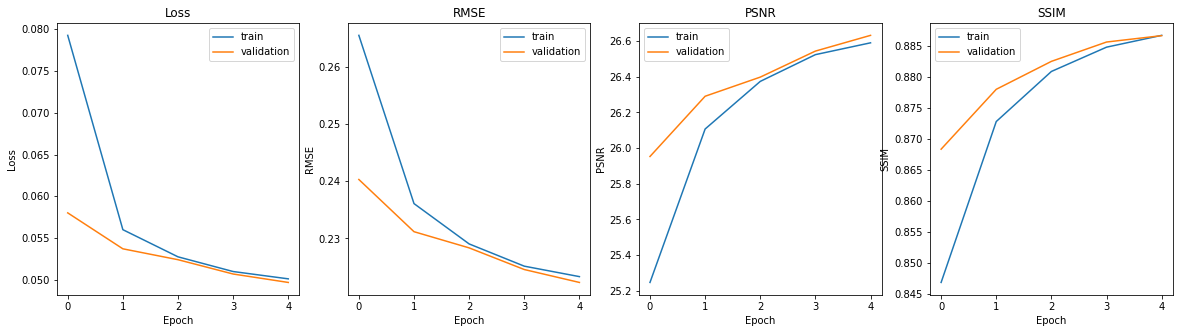

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title(f"Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()

plt.subplot(1,4,2)
plt.title(f"RMSE")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.plot(train_rmse, label='train')
plt.plot(val_rmse, label='validation')
plt.legend()

plt.subplot(1,4,3)
plt.title(f"PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(train_psnr, label='train')
plt.plot(val_psnr, label='validation')
plt.legend()


plt.subplot(1,4,4)
plt.title(f"SSIM")
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(train_ssim, label='train')
plt.plot(val_ssim, label='validation')
plt.legend()




